In [1]:
# This code is written to support the experiments in the book titled:
# "Adaptive Machine Learning Algorithms"
# by
# Chanchal Chatterjee and Vwani P. Roychowdhury
# August 2021
#
# Experiments for Chapter 5 - Principal and Minor Eigenvectors of a Matrix Sequence
# XU - Comparison of Adaptive EVD Homogeneous, Deflated, Weighted
#
# Author: Chanchal Chatterjee
#

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


In [33]:
# Number of samples N and dimension D
nSamples = 1000
nDim     = 10
nEA      = 4
nEpochs  = 1


In [46]:
# Generate the covX random matrices
cov = 10*np.array([ \
    [ 0.4270,  0.0110, -0.0050, -0.0250,  0.0890, -0.0790, -0.0190,  0.0740,  0.0890,  0.0050 ], \
    [ 0.0110,  5.6900, -0.0690, -0.2820, -0.7310,  0.0900, -0.1240,  0.1000,  0.4320, -0.1030 ], \
    [-0.0050, -0.0690,  0.0800,  0.0980,  0.0450, -0.0410,  0.0230,  0.0220, -0.0350,  0.0120 ], \
    [-0.0250, -0.2820,  0.0980,  2.8000, -0.1070,  0.1500, -0.1930,  0.0950, -0.2260,  0.0460 ], \
    [ 0.0890, -0.7310,  0.0450, -0.1070,  3.4400,  0.2530,  0.2510,  0.3160,  0.0390, -0.0100 ], \
    [-0.0790,  0.0900, -0.0410,  0.1500,  0.2530,  2.2700, -0.1800,  0.2950, -0.0390, -0.1130 ], \
    [-0.0190, -0.1240,  0.0230, -0.1930,  0.2510, -0.1800,  0.3270,  0.0270,  0.0260, -0.0160 ], \
    [ 0.0740,  0.1000,  0.0220,  0.0950,  0.3160,  0.2950,  0.0270,  0.7270, -0.0960, -0.0170 ], \
    [ 0.0890,  0.4320, -0.0350, -0.2260,  0.0390, -0.0390,  0.0260, -0.0960,  0.7150, -0.0090 ], \
    [ 0.0050, -0.1030,  0.0120,  0.0460, -0.0100, -0.1130, -0.0160, -0.0170, -0.0090,  0.0650 ]])
print(cov/3)

[[ 1.42333333e+00  3.66666667e-02 -1.66666667e-02 -8.33333333e-02
   2.96666667e-01 -2.63333333e-01 -6.33333333e-02  2.46666667e-01
   2.96666667e-01  1.66666667e-02]
 [ 3.66666667e-02  1.89666667e+01 -2.30000000e-01 -9.40000000e-01
  -2.43666667e+00  3.00000000e-01 -4.13333333e-01  3.33333333e-01
   1.44000000e+00 -3.43333333e-01]
 [-1.66666667e-02 -2.30000000e-01  2.66666667e-01  3.26666667e-01
   1.50000000e-01 -1.36666667e-01  7.66666667e-02  7.33333333e-02
  -1.16666667e-01  4.00000000e-02]
 [-8.33333333e-02 -9.40000000e-01  3.26666667e-01  9.33333333e+00
  -3.56666667e-01  5.00000000e-01 -6.43333333e-01  3.16666667e-01
  -7.53333333e-01  1.53333333e-01]
 [ 2.96666667e-01 -2.43666667e+00  1.50000000e-01 -3.56666667e-01
   1.14666667e+01  8.43333333e-01  8.36666667e-01  1.05333333e+00
   1.30000000e-01 -3.33333333e-02]
 [-2.63333333e-01  3.00000000e-01 -1.36666667e-01  5.00000000e-01
   8.43333333e-01  7.56666667e+00 -6.00000000e-01  9.83333333e-01
  -1.30000000e-01 -3.76666667e-01

In [47]:
from scipy.linalg import eigh

eigvals, eigvecs = eigh(cov)
print("eigvals =\n", eigvals[::-1])

V = np.fliplr(eigvecs)
D  = np.diag(np.sqrt(eigvals[::-1]))
np.random.seed(1)
R = np.random.normal(0, 1, (nDim, nSamples))
X = V @ D @ R


eigvals =
 [59.67112777 34.07069969 28.69281957 21.78690296  7.46521477  6.12287641
  3.78693868  2.56421491  0.74827846  0.50092678]


In [48]:
# Square root of the correlation matrix
from scipy.linalg import eigh

# Compute Correlation matrix and eigen vectors of the generated data
corX = (X @ X.T) / nSamples

# Eigenvalues and eigenvectors of corX
eigvals, eigvecs = eigh(corX)
print("eigvals =\n", eigvals[::-1])

EstV = np.fliplr(eigvecs)
EstD  = np.diag(eigvals[::-1])


eigvals =
 [57.86508461 36.25983174 27.08713941 21.83288307  7.78520053  6.05184381
  3.58947915  2.54696566  0.80377547  0.44662877]


In [60]:
# Adaptive algorithm
from numpy import linalg as la

A  = np.zeros(shape=(nDim,nDim)) # stores adaptive correlation matrix
W2 = 0.1 * np.ones(shape=(nDim,nEA)) # weight vectors of all algorithms
cos_t1 = np.zeros(shape=(nEA, nSamples*nEpochs)) # cosine error
cos_t2 = np.zeros(shape=(nEA, nSamples*nEpochs)) # cosine error

for epoch in range(nEpochs):
    for iter in range(nSamples):
        cnt = nSamples*epoch + iter

        # Update data correlation matrix A with current data sample x
        x = X[:,iter]
        x = x.reshape(nDim,1)
        A = A + (1.0/(1 + cnt))*((np.dot(x, x.T)) - A)

        # Deflated Gradient Descent
        W2 = W2 + (1/(100 + cnt))*(A @ W2 - 0.5 * W2 @ np.triu(W2.T @ A @ W2) - 
                                   0.5 * A @ W2 @ np.triu(W2.T @ W2)) 
        for i in range(nEA):
            u2 = W2[:,i]/la.norm(W2[:,i])
            u2 = u2.reshape(nDim,1)
            vi = EstV[:,i].reshape(nDim,1)
            cos_t2[i,cnt] = abs(u2.T @ vi)
            ED = W2.T @ A @ W2
            cos_t1[i,cnt] = abs(ED[i][i]-EstD[i][i])
            
ED = W2.T @ A @ W2
print([ED[i][i] for i in range(len(ED[0]))])


[57.85703690023348, 36.251191542548575, 27.054232054548294, 21.881394185902]


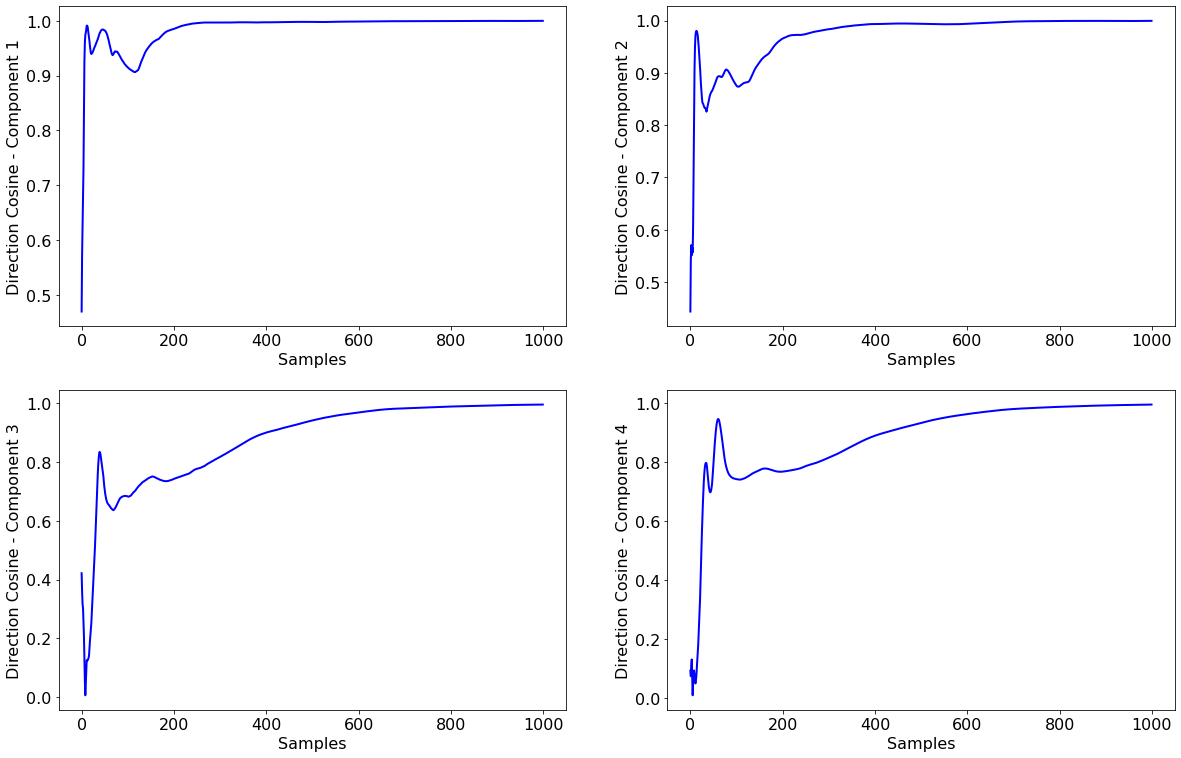

In [61]:
# Plot the Direction cosines of the adaptive eigenvectors with the true eigenvectors

plt.figure(figsize=(20, 20))
plt.rcParams.update({'font.size': 16})

plt.subplot(3, 2, 1)
plt.plot(cos_t2[0,:], lw=2, color='b')
plt.ylabel('Direction Cosine - Component 1')
plt.xlabel('Samples')

plt.subplot(3, 2, 2)
plt.plot(cos_t2[1,:], lw=2, color='b')
plt.ylabel('Direction Cosine - Component 2')
plt.xlabel('Samples')

plt.subplot(3, 2, 3)
plt.plot(cos_t2[2,:], lw=2, color='b')
plt.ylabel('Direction Cosine - Component 3')
plt.xlabel('Samples')

plt.subplot(3, 2, 4)
plt.plot(cos_t2[3,:], lw=2, color='b')
plt.ylabel('Direction Cosine - Component 4')
plt.xlabel('Samples')

plt.show()

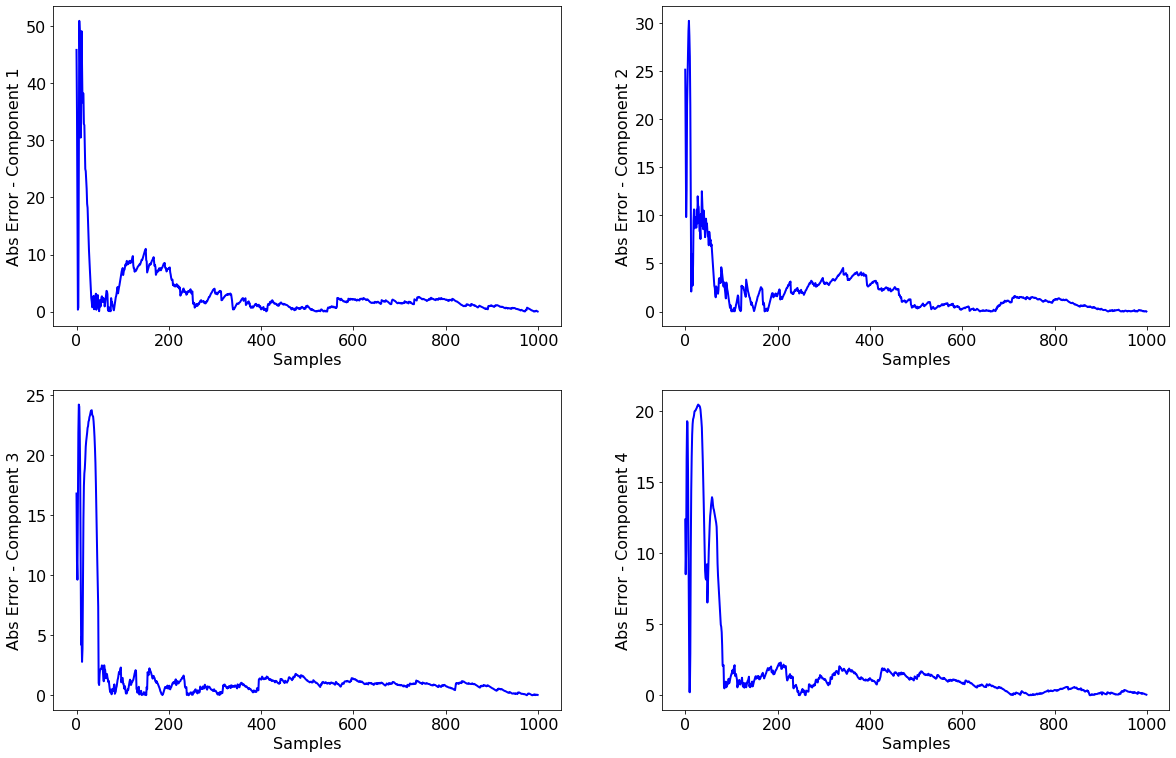

In [63]:
# Plot the errors of the adaptive eigenvalues with the true eigenvalues

plt.figure(figsize=(20, 20))
plt.rcParams.update({'font.size': 16})

plt.subplot(3, 2, 1)
plt.plot(cos_t1[0,:], lw=2, color='b')
plt.ylabel('Abs Error - Component 1')
plt.xlabel('Samples')

plt.subplot(3, 2, 2)
plt.plot(cos_t1[1,:], lw=2, color='b')
plt.ylabel('Abs Error - Component 2')
plt.xlabel('Samples')

plt.subplot(3, 2, 3)
plt.plot(cos_t1[2,:], lw=2, color='b')
plt.ylabel('Abs Error - Component 3')
plt.xlabel('Samples')

plt.subplot(3, 2, 4)
plt.plot(cos_t1[3,:], lw=2, color='b')
plt.ylabel('Abs Error - Component 4')
plt.xlabel('Samples')

plt.show()